In [1]:
from os import path
import random

import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, f1_score, accuracy_score, recall_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set to seer or cohort
TARGET = "cohort"

In [3]:
SEED = 491
random.seed(SEED)
np.random.seed(SEED)

In [4]:
data_path = "data/previous"
processed_seer = path.join(data_path, "processed_seer_with_age.csv")
processed_cohort = path.join(data_path, "processed_cohort_with_age.csv")
seer_dataset = pl.read_csv(processed_seer)
cohort_dataset = pl.read_csv(processed_cohort)

In [5]:
seer_dataset

age,PSA,clinical_stage,ISUP_grade,biopsy_cores_positive,biopsy_cores_examined,target
i64,f64,i64,i64,i64,i64,i64
57,31.5,3,2,12,12,0
69,12.0,1,1,1,12,0
69,3.6,2,1,6,14,0
80,3.4,2,5,7,9,1
62,17.2,1,4,4,25,0
…,…,…,…,…,…,…
65,6.0,1,2,6,12,0
61,52.7,1,3,11,14,0
51,18.7,1,1,5,12,0


In [6]:
cohort_dataset

age,PSA,clinical_stage,ISUP_grade,biopsy_cores_positive,biopsy_cores_examined,target
i64,f64,i64,i64,i64,i64,i64
59,5.3,2,5,10,16,1
53,10.73,1,3,9,12,1
71,6.14,2,3,9,12,0
60,13.6,1,3,2,12,0
75,36.0,1,5,9,12,0
…,…,…,…,…,…,…
58,6.46,2,1,10,16,0
77,4.07,2,4,6,15,1
69,16.3,2,4,7,15,0


In [7]:
# Choose which dataset to train on, which to evaluate
TRAIN = cohort_dataset if TARGET == "seer" else seer_dataset
TEST = seer_dataset if TARGET == "seer" else cohort_dataset

In [8]:
label_col = "target"

X_seer = TRAIN.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_seer = TRAIN.get_column(label_col).to_numpy().astype(np.int64).ravel()
X_train, X_val, y_train, y_val = train_test_split(X_seer, y_seer, test_size=0.2, stratify=y_seer, random_state=491)

X_test = TEST.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_test = TEST.get_column(label_col).to_numpy().astype(np.int64).ravel()

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SVM": SVC(
        kernel="rbf",
        C=2.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=SEED
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=4,
        class_weight="balanced_subsample",
        random_state=SEED,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=SEED,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

pl.DataFrame(results).sort(by="AUC", descending=True)

Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""Logistic Regression""",0.828613,0.826531,0.5,0.029412,0.055556
"""XGBoost""",0.804285,0.719388,0.363636,0.823529,0.504505
"""SVM""",0.787945,0.673469,0.3125,0.735294,0.438596
"""Random Forest""",0.724219,0.821429,0.4,0.058824,0.102564


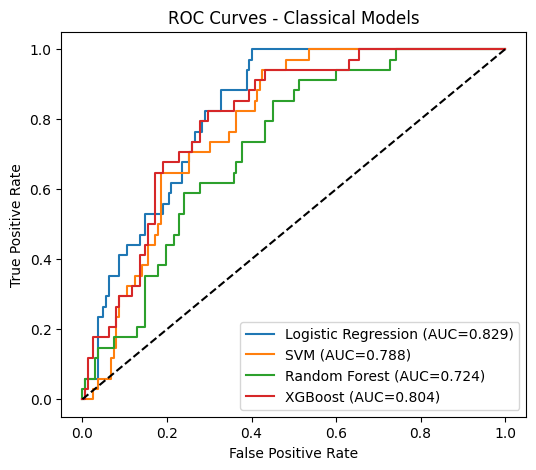

In [11]:
plt.figure(figsize=(6, 5))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Classical Models")
plt.legend()
plt.show()